# Main

### b), c), d), e), f) and optionals ...

## Part b) Writing your own Neural Network code

##### 1) Writing your own FFNN code

Writing your own **FFNN** code, with implementation of the **backpropagation** algorithm. Stil focusing on the regression problem of the one-dimensional **Runge function**. 

**You should scale the data, and comment on it!**

Using only the **mean-squared error** as cost function (no regularization terms). Flexible number of hidden layyers. Initialize the weights using a **normal distribution**. 

- How would you normalize the biases? 
- And which activation function would you select for the final output layer?
- And how would you set up yout design/feature matrix? *Hint: does it have to represent a polynomial approximation as you did in project 1?*

In [1]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import time
import autograd.numpy as np
import numpy as np
from autograd import grad, elementwise_grad
from typing import Tuple, List
import seaborn as sns

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.size": 12,
#})

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions import *

%load_ext autoreload
%autoreload 2

In [2]:
# Scikit-Learn :
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Tensorflow-Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam     # NB! Remember this definition !!
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2      # NB! Remember this definition !!

# PyTorch : 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
n = 200
x = np.linspace(-1, 1, n)
x = x.reshape(-1, 1)

y = runge_function(x) + np.random.normal(0, 0.1, (n,1))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std
X_test_norm  = (X_test - X_mean) / X_std

In [4]:
# All data used :
#inputs  = x
#targets = y
# Split into test and train :
inputs  = X_train_norm
targets = y_train
# Optionally add validationsplit :
# inputs  = ...
# targets = ...

x_test  = X_test_norm
y_test  = y_test

##### 2) Compare the network to the results from project 1

Train yout network and **compare** the results with those from your **OLS** regression code from project 1, and comment the result with a critical discussion;
- Using the same data sets which gave you the best result
- The polynomial order that gave the best result
- Compare with your neural network with one and two hidden layers using 50 and 100 hidden nodes, respectively

##### 3) Analysis of the learning rate

Make an analysis of the **learning rates** employed to find the optimal MSE score
- Stochastic gradient decent vs. plain gradient decent with:
    - RMSprop
    - ADAM


In [5]:
reg_nn_adam    = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_RMSProp = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)
reg_nn_gd      = NeuralNetwork(1, [8, 1], [sigmoid, identity], [derivate(sigmoid), derivate(identity)], mse, mse_der)

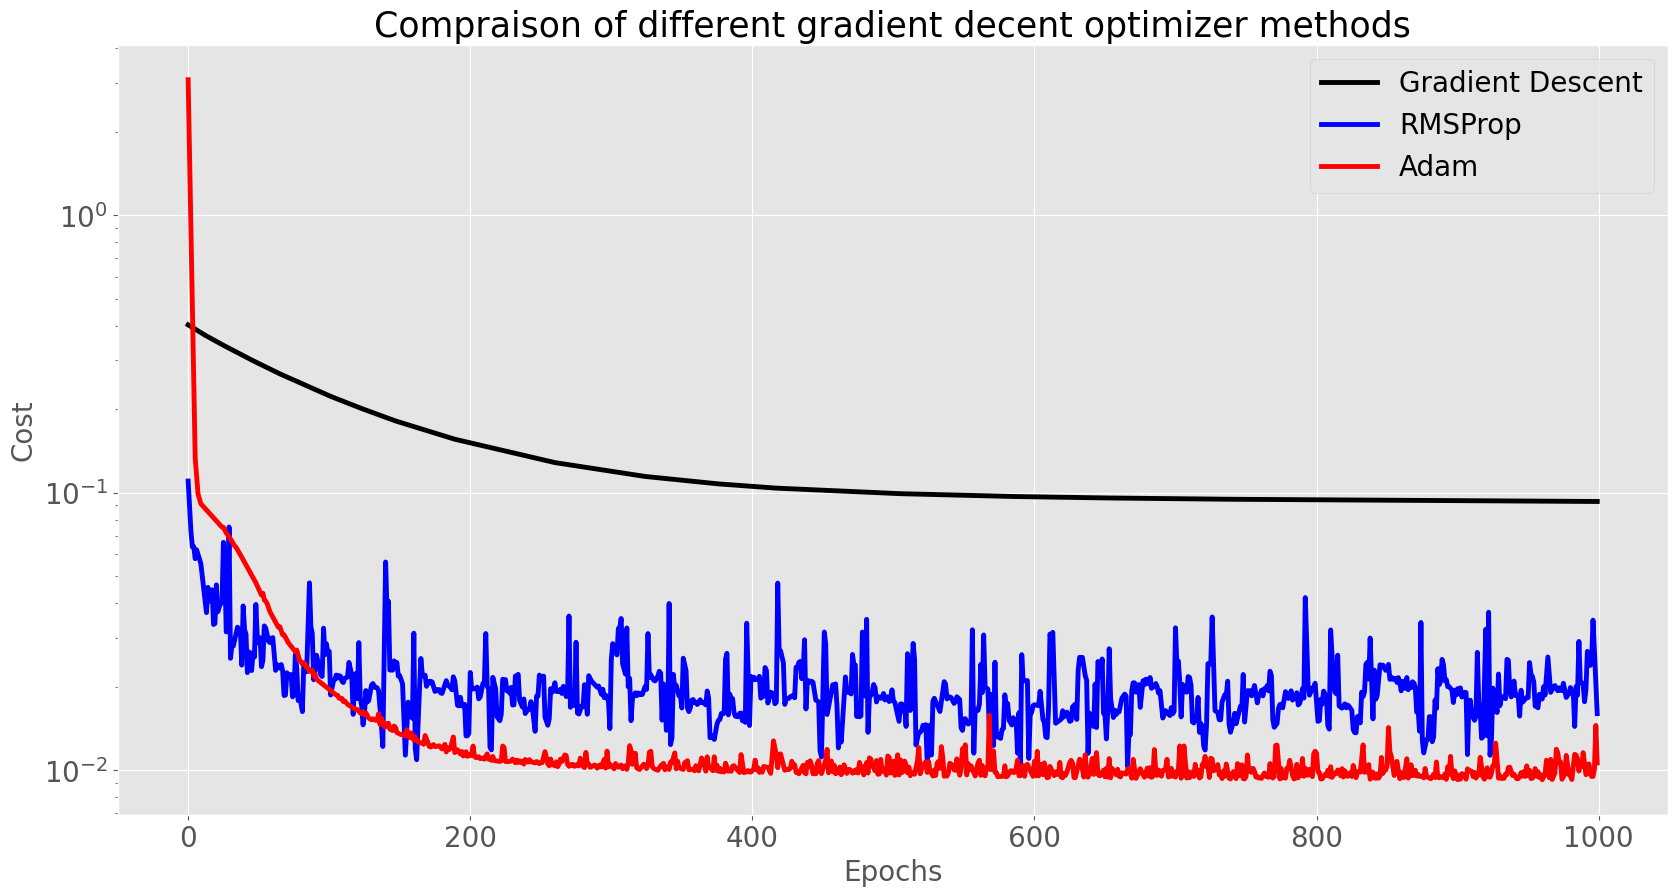

In [6]:
reg_nn_adam.train_SGD(inputs, targets,    epochs=1000, learning_rate=0.01, batch_size=16, optimizer="Adam")
reg_nn_RMSProp.train_SGD(inputs, targets, epochs=1000, learning_rate=0.01, batch_size=16, optimizer="RMSProp")
reg_nn_gd.train_SGD(inputs, targets,      epochs=1000, learning_rate=0.01, batch_size=16)

plt.figure(figsize=(20,10))
plt.plot(reg_nn_gd.training_info["Cost_history"],      c='k', linewidth=3.5, linestyle='-', label="Gradient Descent")
plt.plot(reg_nn_RMSProp.training_info["Cost_history"], c='b', linewidth=3.5, linestyle='-', label="RMSProp")
plt.plot(reg_nn_adam.training_info["Cost_history"],    c='r', linewidth=3.5, linestyle='-', label="Adam")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.yscale("log")
plt.title("Compraison of different gradient decent optimizer methods", fontsize=25)
plt.legend(fontsize=20)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust font size here
plt.show()

## Part c) Testing agains other software libraries

##### 1) Test against Scikit-Learn, tensorflow.keras or PyTorch

You should test your results against a similar code using **Scikit-Learn** (see the examples in the above lecture notes from weeks 41 and 42) or **tensorflow/keras** or **Pytorch** (for Pytorch, see Raschka et al.'s text chapters 12 and 13). 

**Add to FFNN:**
- **Add choice of beta1 and beta2**
- **Add shuffle choice**
- **Add tolerance for stopping?**

In [7]:
network_input_size = 1
seed               = None # Determines random number generation for weights and bias initialization?

# Define hyperparameters:
learning_rate = 0.01  # The initial learning rate used. It controls the step-size in updating the weights. 
epochs        = 1000  # Number of total iterations.
batch_size    = 16    # Size of minibatches for stochastic optimizers.

# Only used when solver=’adam’: NB!! Hard-coded in FFNN, make it as choice!?
beta_1        = 0.9   # Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1).
beta_2        = 0.999 # Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1).

# Scikit-learn specific:
scikit_lr_type             = 'adaptive' # 'constant', 'adaptive' or 'invscaling'
scikit_alpha               = 0          # L2 regularization term
scikit_shuffle             = True       # Whether to shuffle samples in each iteration. Only used when solver=’sgd’ or ‘adam’.
scikit_tol                 = 1e-15      # Tolerance for the optimization. When the loss or score is not improving by at least 
                                        # tol for n_iter_no_change consecutive iterations, unless learning_rate is set to ‘adaptive’, 
                                        # convergence is considered to be reached and training stops.
scikit_verbose             = False      # Whether to print progress messages to stdout.
scikit_warm_start          = False      # When set to True, reuse the solution of the previous call to fit as initialization, otherwise, 
                                        # just erase the previous solution. 
scikit_momentum            = 0.9        # Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.
scikit_nesterovs_momentum  = False      # Whether to use Nesterov’s momentum. Only used when solver=’sgd’ and momentum > 0.
scikit_early_stopping      = False      # Whether to use early stopping to terminate training when validation score is not improving.
scikit_validation_fraction = 0          # The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. 
                                        # Only used if early_stopping is True.
scikit_epsilon             = 1e-8       # Value for numerical stability in adam. Only used when solver=’adam’.
scikit_n_iter_no_change    = epochs     # Maximum number of epochs to not meet tol improvement. Only effective when solver=’sgd’ or ‘adam’.
                                        # For it to run until the end, keep this as big as the epochs !
# Keras specific:
keras_verbose  = 0 # Whether to print progress messages to stdout. 1 is print
scikit_shuffle = True

# PyTorch specific:
pytorch_shuffle = True

# Network arcitecture:
FFNN_layers   = [8, 1] # The last element is the outputlayer ?
scikit_layer  = (8, 1)   # The ith element represents the number of neurons in the ith hidden layer.
keras_layers  = [8, 1] # The last element is the outputlayer.
torch_layers1 = nn.Linear(1, 8)   # Input layer to hidden layer
torch_layers2 = nn.Linear(8, 1)   # Hidden layer to output layer

# Cost function:
FFNN_cost_fun     = mse
FFNN_cost_fun_der = mse_der
keras_cost_fun    = 'mean_squared_error'

# Activation functions:
FFNN_act_fun     = [sigmoid, sigmoid]
FFNN_act_fun_der = [derivate(sigmoid), derivate(sigmoid)]
scikit_act_fun   = 'logistic' # 'identity', 'logistic', tanh', 'relu' --> NB! No option for sigmoid, but logistic should be the same?
keras_act_fun    = ['sigmoid', 'linear']
#torch_act_fun1   = torch.sigmoid(self.hidden(x))   # Sigmoid activation function for hidden layer
#torch_act_fun2   = self.output(x)                  # Linear activation for output layer

# Solver/optimizer:
FFN_solver    = 'Adam'
scikit_solver = 'adam' #'adam', 'sgd', 
keras_solver  = Adam(learning_rate = learning_rate, 
                     beta_1        = beta_1, 
                     beta_2        = beta_2, 
                     epsilon       = scikit_epsilon) # SGD(learning_rate=learning_rate)

In [8]:
# Initialize the network, so that the weights are not remembered
Regression_FFNN = NeuralNetwork(network_input_size,
                                FFNN_layers, 
                                FFNN_act_fun, 
                                FFNN_act_fun_der, 
                                FFNN_cost_fun, 
                                FFNN_cost_fun_der)
# Start the timer
start_time = time.time()
# Train the model
Regression_FFNN.train_SGD(inputs, targets, 
                          learning_rate = learning_rate, 
                          epochs        = epochs,  
                          batch_size    = batch_size, 
                          optimizer     = FFN_solver)
# Make predictions
y_pred = Regression_FFNN._feed_forward(x_test)
# Calculate mean squared error
mse_proj2  = mse(y_test, y_pred)
mse_proj22 = mean_squared_error(y_test, y_pred)
# Calculate elapsed time
elapsed_time_FFNN = time.time() - start_time
# Print results
print(f"Project-2 MSE: {mse_proj2}")
print(f"Project-2 MSE: {mse_proj22}")
print(f"Elapsed time: {elapsed_time_FFNN:.2f} seconds")

Project-2 MSE: 0.022383120066186528
Project-2 MSE: 0.022383120066186528
Elapsed time: 8.95 seconds


In [9]:
# Start the timer
start_time = time.time()
# Create and train the Scikit-Learn model --> Multi-layer Perceptron regressor : 
sklearn_model = MLPRegressor(#loss='squared_error', 
                            hidden_layer_sizes  = scikit_layer, 
                            activation          = scikit_act_fun,
                            solver              = scikit_solver,
                            alpha               = scikit_alpha,
                            batch_size          = batch_size,
                            learning_rate       = scikit_lr_type,
                            learning_rate_init  = learning_rate, 
                            #power_t=0.5, # The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to ‘invscaling’. Only used when solver=’sgd’.
                            max_iter            = epochs, 
                            shuffle             = scikit_shuffle, 
                            random_state        = seed, 
                            tol                 = scikit_tol, 
                            verbose             = scikit_verbose,
                            warm_start          = scikit_warm_start,
                            momentum            = scikit_momentum,
                            nesterovs_momentum  = scikit_nesterovs_momentum,
                            early_stopping      = scikit_early_stopping,
                            validation_fraction = scikit_validation_fraction,
                            beta_1              = beta_1,
                            beta_2              = beta_2,
                            epsilon             = scikit_epsilon,
                            n_iter_no_change    = scikit_n_iter_no_change,
                            #max_fun=15000, # Only used when solver=’lbfgs’. 
                            )
sklearn_model.fit(inputs, targets.ravel())
# Predictions
y_pred_sklearn = sklearn_model.predict(x_test)
# Calculate mean squared error
mse_sklearn  = mse(y_test.flatten(), y_pred_sklearn)
mse_sklearn2 = mean_squared_error(y_test, y_pred_sklearn)
# Calculate elapsed time
elapsed_time_scikit = time.time() - start_time
print(f"Scikit-Learn MSE: {mse_sklearn}")
print(f"Scikit-Learn MSE: {mse_sklearn2}")
print(f"Elapsed time: {elapsed_time_scikit:.2f} seconds")

Scikit-Learn MSE: 0.021586360915184656
Scikit-Learn MSE: 0.021586360915184656
Elapsed time: 5.00 seconds


c:\Users\Ingvild\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:
# Signs of overfitting?
train_loss = sklearn_model.loss_curve_
final_train_loss = train_loss[-1]  # Get last loss in curve
mse_calculated = mean_squared_error(y_test, y_pred_sklearn) 
print(f"Final training loss (from curve): {final_train_loss}")
print(f"Calculated MSE from test data: {mse_calculated}")

Final training loss (from curve): 0.0048039985340511526
Calculated MSE from test data: 0.021586360915184656


In [11]:
# Create a simple feedforward neural network using Keras
model = Sequential()
model.add(Dense(keras_layers[0], activation=keras_act_fun[0], input_dim=network_input_size))  # 1 input, 8 hidden neurons
model.add(Dense(keras_layers[1], activation=keras_act_fun[1]))                                # Output layer
# Regularization options : 
#model.add(Dense(keras_layers[0], activation=keras_act_fun[0], input_dim=network_input_size, kernel_regularizer=l2(0.01)))  # 1 input, 8 hidden neurons
#model.add(Dense(keras_layers[1], activation=keras_act_fun[1], kernel_regularizer=l1(0.01))) 
# Compile the model with optimkeras_solverizer
model.compile(loss=keras_cost_fun, optimizer=keras_solver)
# Define the prediction function
@tf.function(reduce_retracing=True)
def predict_fn(x):
    return model(x)
# Start the timer
start_time = time.time()
# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', 
#                               patience=5, 
#                               min_delta=1e-4, 
#                               restore_best_weights=True)
# Train the model and capture the loss history
history = model.fit(inputs, targets, 
                    epochs     = epochs, 
                    batch_size = batch_size, 
                    verbose    = keras_verbose,
                    #validation_split = 0,
                    shuffle     = scikit_shuffle,
                    #callbacks  = [early_stopping]
                    )
# Predictions
#y_pred_keras = model.predict(x) # OLD
y_pred_keras = predict_fn(x_test).numpy()  # Convert from tensor to numpy
# Calculate mean squared error
mse_keras  = mse(y_test, y_pred_keras)
mse_keras2 = mean_squared_error(y_test, y_pred_keras)
# Calculate elapsed time
elapsed_time_keras = time.time() - start_time
print(f"Tensorflow-Keras MSE: {mse_keras}")
print(f"Tensorflow-Keras MSE: {mse_keras2}")
print(f"Elapsed time: {elapsed_time_keras:.2f} seconds")

c:\Users\Ingvild\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tensorflow-Keras MSE: 0.023107332380090745
Tensorflow-Keras MSE: 0.023107332380090745
Elapsed time: 93.45 seconds


In [12]:
# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define a simple feedforward neural network
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.hidden = torch_layers1
        self.output = torch_layers2
    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))   # Sigmoid activation function for hidden layer
        x = self.output(x)                  # Linear activation for output layer
        return x
# Prepare data
x_tensor = torch.tensor(inputs, dtype=torch.float32).view(-1, 1).to(device)   # Reshape for PyTorch
y_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1).to(device)  # Reshape and send to device
# Create a TensorDataset and DataLoader
dataset     = TensorDataset(x_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=pytorch_shuffle)  # shuffle=True to shuffle the data
# Initialize the model, loss function and optimizer
#model     = FeedForwardNN()
model = FeedForwardNN().to(device)  # Move model to device
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Changed from SGD to Adam
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)  # L2 regularization with weight_decay
# Prepare for early stopping
#best_loss = float('inf')
#patience = 5  # Number of epochs with no improvement after which training will be stopped
#early_stopping_counter = 0
# Start the timer
start_time = time.time()
# List to store loss values
loss_history = []
# Training loop
for epoch in range(epochs):
    model.train()                        # Set model to training mode
    optimizer.zero_grad()                # Clear the gradients
    outputs = model(x_tensor)            # Forward pass
    loss = criterion(outputs, y_tensor)  # Calculate loss
    loss.backward()                      # Backward pass (gradient calculation)
    optimizer.step()                     # Update weights
    # Store loss for plotting
    loss_history.append(loss.item())
    # Early stopping logic
    #if (epoch + 1) % 10 == 0:  # Check for improvement every 10 epochs
        #model.eval()  # Set model to evaluation mode
        #with torch.no_grad():
            #val_loss = criterion(model(x_tensor), y_tensor).item()  # Calculate validation loss
        #if val_loss < best_loss - 1e-4:  # Check if the loss improved by at least the tolerance
            #best_loss = val_loss
            #early_stopping_counter = 0  # Reset counter
        #else:
            #early_stopping_counter += 1
        #if early_stopping_counter >= patience:  # Stop training early
            #print(f'Early stopping at epoch {epoch + 1}')
            #break
# Predictions
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 1).to(device)   # Reshape for PyTorch
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # disable gradient calculation for evaluation 
    y_pred_pytorch = model(x_test_tensor).cpu().numpy()  # Move tensor to CPU and convert to numpy
#y_pred_pytorch = model(x_tensor).detach().numpy()
# Calculate mean squared error
mse_pytorch  = mse(y_test, y_pred_pytorch)
mse_pytorch2 = mean_squared_error(y_test, y_pred_pytorch)
# Calculate elapsed time
elapsed_time_pytorch = time.time() - start_time
# Print results
print(f"PyTorch MSE: {mse_pytorch}")
print(f"PyTorch MSE: {mse_pytorch2}")
print(f"Elapsed time: {elapsed_time_pytorch:.2f} seconds")

PyTorch MSE: 0.022641038744902055
PyTorch MSE: 0.022641038744902055
Elapsed time: 2.25 seconds


In [13]:
# # Plotting the cost history
# plt.figure(figsize=(20,10))
# plt.plot(Regression_FFNN.get_info()["Cost_history"], c='k', linewidth=3.5, linestyle='-', label=f'FFNN, {elapsed_time_FFNN:.2f} sec, MSE:{mse_proj2:.4f}')
# plt.plot(sklearn_model.loss_curve_, c='g', linewidth=3.5, linestyle='-', label=f'Scikit-Learn, {elapsed_time_scikit:.2f} sec, MSE:{mse_sklearn:.4f}')
# plt.plot(history.history['loss'], c='b', linewidth=3.5, linestyle='-', label=f'Tensorflow-Keras, {elapsed_time_keras:.2f} sec, MSE:{mse_keras:.4f}')
# plt.plot(loss_history, c='r', linewidth=3.5, linestyle='-', label=f'PyTorch, {elapsed_time_pytorch:.2f} sec, MSE:{mse_pytorch:.4f}')
# plt.xlabel("Epochs", fontsize=20)
# plt.ylabel("Cost", fontsize=20)
# plt.yscale("log")
# plt.title("Comparing FFNN to Libraries with layers=[8,1], and optimizer=ADAM", fontsize=25)
# plt.legend(fontsize=20)
# # Increase tick label font size 
# plt.tick_params(axis='both', which='major', labelsize=20)  # Adjust font size here
# plt.show()

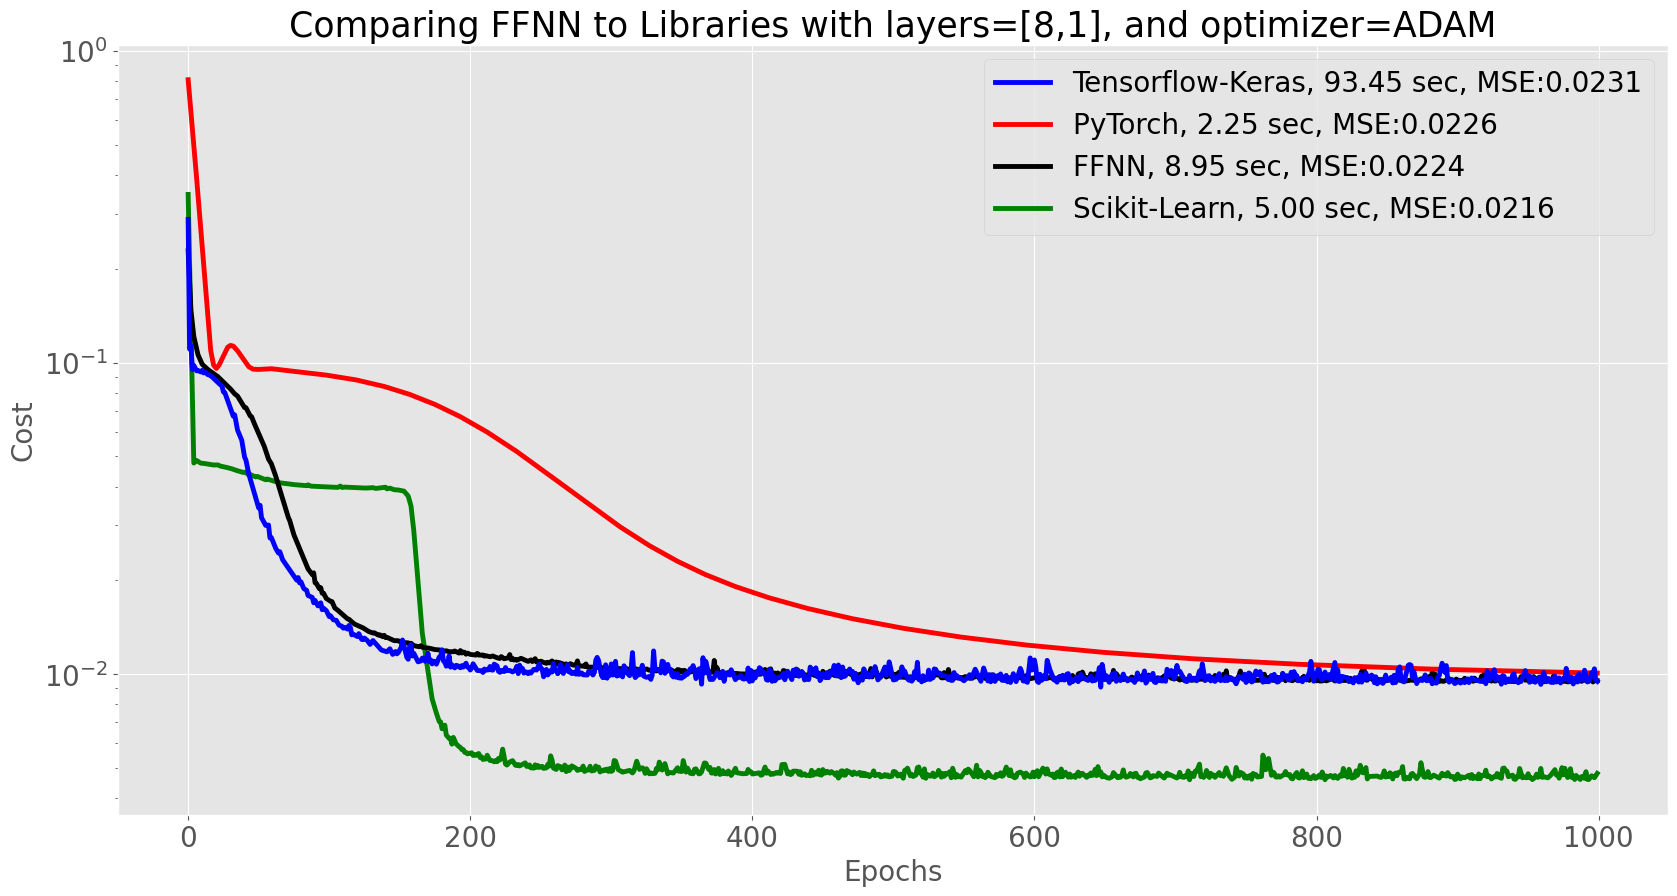

In [14]:
# Create a list of (MSE, plot data) tuples
plot_data = [
    (mse_proj2, (Regression_FFNN.get_info()["Cost_history"], 'k', 'FFNN', elapsed_time_FFNN)),
    (mse_sklearn, (sklearn_model.loss_curve_, 'g', 'Scikit-Learn', elapsed_time_scikit)),
    (mse_keras, (history.history['loss'], 'b', 'Tensorflow-Keras', elapsed_time_keras)),
    (mse_pytorch, (loss_history, 'r', 'PyTorch', elapsed_time_pytorch)),
]
# Sort the data by MSE in descending order
plot_data.sort(key=lambda x: x[0], reverse=True)
# Plot the data
plt.figure(figsize=(20,10))
for mse, (data, color, label, elapsed_time) in plot_data:
    plt.plot(data, c=color, linewidth=3.5, linestyle='-', 
             label=f'{label}, {elapsed_time:.2f} sec, MSE:{mse:.4f}', 
             zorder=mse * 1000)  # Use MSE for zorder
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Cost", fontsize=20)
plt.yscale("log")
plt.title("Comparing FFNN to Libraries with layers=[8,1], and optimizer=ADAM", fontsize=25)
plt.legend(fontsize=20)
# Increase tick label font size
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()

##### 2) Test against Autograd or 

Also test that your derivatives are correctly
calculated using automatic differentiation, using for example the
**Autograd** library or the **JAX** library. It is optional to implement
these libraries for the present project. In this project they serve as
useful tests of our derivatives.

In [15]:
import autograd.numpy as np
from autograd import grad

# Define the cost function for a one-layer neural network
def cost_one_layer(W, b, x, target):
    z = np.dot(W, x) + b
    a = 1.0 / (1 + np.exp(-z))  # Sigmoid activation
    return np.mean((a - target) ** 2)  # Mean squared error

# Mean Squared Error derivative
def mse_der(predict, target):
    target = target.reshape(-1)  # Ensure target is a 1D array
    assert predict.shape == target.shape, "Not same"
    return 2 * (predict - target) / target.size

# Sigmoid activation function
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Derivative of sigmoid function
def sigmoid_der(z):
    sig = sigmoid(z)
    return sig * (1 - sig)

# Random input and target for testing
x = np.random.rand(2)
target = np.random.rand(3)

# Random weights and bias
W = np.random.rand(3, 2)
b = np.random.rand(3)

# Calculate gradients using autograd
autograd_one_layer = grad(cost_one_layer, [0, 1])

# Compute the activations and predictions
z = W @ x + b
a = sigmoid(z)
predict = a

# Calculate the derivatives for backpropagation
dC_da = mse_der(predict.reshape(-1), target)  # Ensure same shape

da_dz = sigmoid_der(z)

dC_dz = dC_da * da_dz

dC_dW = np.outer(dC_dz, x)  # Gradient wrt weights

dC_db = dC_dz  # Gradient wrt biases

# Print the computed gradients and derivatives
print("\n--- Backpropagation Derivatives ---")
print(f"Weight Gradient (dC/dW):\n{dC_dW}\n")
print(f"Bias Gradient (dC/db):\n{dC_db}\n")

# Compute the gradients using autograd
W_g, b_g = autograd_one_layer(W, b, x, target)

# Print autograd gradients
print("--- Autograd Gradients ---")
print(f"Weight Gradient from Autograd (dC/dW):\n{W_g}\n")
print(f"Bias Gradient from Autograd (dC/db):\n{b_g}\n")

# Optional: compare the results to see if they're similar
print("--- Comparison of Gradients ---")
print(f"Difference in Weight Gradients:\n{W_g - dC_dW}\n")
print(f"Difference in Bias Gradients:\n{b_g - dC_db}\n")



--- Backpropagation Derivatives ---
Weight Gradient (dC/dW):
[[0.02939973 0.03245688]
 [0.02402509 0.02652335]
 [0.0057974  0.00640024]]

Bias Gradient (dC/db):
[0.09513324 0.07774168 0.01875953]

--- Autograd Gradients ---
Weight Gradient from Autograd (dC/dW):
[[0.02939973 0.03245688]
 [0.02402509 0.02652335]
 [0.0057974  0.00640024]]

Bias Gradient from Autograd (dC/db):
[0.09513324 0.07774168 0.01875953]

--- Comparison of Gradients ---
Difference in Weight Gradients:
[[-3.46944695e-18 -6.93889390e-18]
 [-3.46944695e-18 -3.46944695e-18]
 [-8.67361738e-19 -8.67361738e-19]]

Difference in Bias Gradients:
[-1.38777878e-17 -1.38777878e-17 -3.46944695e-18]



## Part d) Testing different activation functions and depths of the neural network

##### 1) Different activation functions
You should also test different activation functions for the hidden layers. Try out the Sigmoid, the RELU and the Leaky RELU functions and discuss your results.

##### 2) Different number of hidden layers and nodes
Test your results as functions of the number of hidden layers and nodes. Do you see signs of overfitting? It is optional in this project to perform a bias-variance trade-off analysis.

## Part e) Testing different norms

##### 1) Find the optimal parameters for the neural network

Still using the **one-dimensional Runge function**, add now the
hyperparameters $\lambda$ with the $L_2$ and $L_1$ norms.  Find the
optimal results for the hyperparameters $\lambda$ and the learning
rates $\eta$ and neural network architecture.

##### 2) Compare to project 1

Compare the $L_2$ results with **Ridge** regression from project 1 and the $L_1$ results with the **Lasso** calculations of project 1. Use again the same data sets and the best results from project 1 in your comparisons.

## Part f) Classification analysis using neural networks

##### 1) Change the network (activation function) for the output layer

- Change the **cost function** in order to performa a classification analysis
- The dataset we will study is the multiclass **MINST** problem (**Optional**: zalando MINST dataset)
- Using the **softmax cross entropy function**
- Consider **Scaling** the data!
- Using the **accuracy score** to measure the performance

##### 2) Discuss the hyperparameters

Discuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter $\lambda$, various activation functions, number of hidden layers and nodes and activation functions.

##### 3) (Strongly recomended) Compare to other libraries

We strongly recommend that you compare your own neural Network
code for classification and pertinent results against a similar code using **Scikit-Learn**  or **tensorflow/keras** or **pytorch**.

If you have time, you can use the functionality of **scikit-learn** and compare your neural network results with those from Logistic regression. This is optional.
The weblink  here <https://medium.com/ai-in-plain-english/comparison-between-logistic-regression-and-neural-networks-in-classifying-digits-dc5e85cd93c3>compares logistic regression and FFNN using the so-called MNIST data set. You may find several useful hints and ideas from this article. Your neural network code can implement the equivalent of logistic regression by simply setting the number of hidden layers to zero and keeping just the input and the output layers. 

### Part g) Critical evaluation of the various algorithms

You should now summarize the various algorithms and come with a critical evaluation of their pros and cons. 
- Which algorithm works best for the regression case and which
is best for the classification case?

##### **Required Analysis:**

1. Briefly show and argue for the **advantages and disadvantages of the methods from Project 1.**

2. Explore and show the **impact** of changing the **number of layers, nodes per layer, choice of activation function, and inclusion of L1 and L2 norms**. Present only the most interesting results from this exploration. **2D Heatmaps** will be good for this: Start with finding a well performing set of hyper-parameters, then change two at a time in a range that shows good and bad performance.

3. Show and argue for the **advantages and disadvantages of using a neural network for regression on your data.**

4. Show and argue for the **advantages and disadvantages of using a neural network for classification on your data.**

5. Show and argue for the **advantages and disadvantages of the different gradient methods and learning rates when training the neural network.**


## Optional (at least two)


1. Implement **Logistic Regression as simple classification model case** (equivalent to a Neural Network with just the output layer)

2. Compute the gradient of the neural network with **autograd**, to show that it gives the same result as your **hand-written backpropagation**.

3. **Compare** your results with results from using a **machine-learning library** like pytorch (https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

4. Use a **more complex classification dataset** instead, like the fashion MNIST (see <https://www.kaggle.com/datasets/zalando-research/fashionmnist>)

5. Use a **more complex regression dataset** instead, like the two-dimensional Runge function $f(x,y)=\left[(10x - 5)^2 + (10y - 5)^2 + 1 \right]^{-1}$, or even more complicated two-dimensional functions (see the supplementary material of <https://www.nature.com/articles/s41467-025-61362-4> for an extensive list of two-dimensional functions). 

6. **Compute and interpret a confusion matrix of your best classification model** (see <https://www.researchgate.net/figure/Confusion-matrix-of-MNIST-and-F-MNIST-embeddings_fig5_349758607>)